In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from gender_guesser import detector

In [2]:
gender = detector.Detector(case_sensitive=False)

In [3]:
years = []
for year in range(1996,2018):
    if year == 1996:
        continue
    try:
        yearStr = str(year)
        columns = [
            'Sector',
            'LastName',
            'FirstName',
            'Salary',
            'TaxableBenefits',
            'Employer',
            'JobTitle',
            'CalendarYear'
        ]
        df = pd.read_csv(
            'data/ontario/'+yearStr + '.csv',
            encoding='latin-1',
            names=columns,
            skiprows=1
        )
        # Fix the calendar year
        df.CalendarYear = year
        df.Salary = df.Salary.replace('[\$,]', '', regex=True).astype(float)
        years.append(df)
    except FileNotFoundError:
        print('Did not find: ' + str(year) + '.csv')
df = pd.concat(years,ignore_index=True)

In [4]:
df.head()

,Sector,LastName,FirstName,Salary,TaxableBenefits,Employer,JobTitle,CalendarYear
0,Colleges,Gillett,Robert,126843.08,"$15,237.07",Algonquin,President,1997
1,Colleges,Hanson,Raymonde,102604.32,"$5,502.22",Algonquin,"V.P., Academic",1997
2,Colleges,Mitchelson,Robert,106199.60,"$5,528.80",Algonquin,"V.P., Finance & Administration",1997
3,Colleges,Crombie,Glenn,115811.32,"$2,995.34",Cambrian,President,1997
4,Colleges,Henderson,Catherine,127313.00,"$19,034.97",Centennial College,President,1997


Drop any empty data

In [5]:
df.dropna(subset=['FirstName','LastName','Sector'],inplace=True)

If we have any duplicates, get rid of both of them. We can't handle duplicates.

In [6]:
# Remove all duplicates so we don't have to deal with them later
df.drop_duplicates(subset = ['LastName', 'FirstName', 'Sector', 'CalendarYear'], keep=False, inplace=True)

Give an id to each unique First + Last + Sector

In [7]:
df['id'] = df.FirstName + df.LastName + df.Sector

In [8]:
np.random.seed(0)
sample = df.loc[df.id.isin(np.random.choice(df.id.unique(),100000,False))].copy()

Get the year of each worker salary

In [9]:
sample.set_index('id',inplace=True)

In [10]:
sample['startYear'] = sample.groupby(sample.index).CalendarYear.min()

In [11]:
sample['year'] = sample.CalendarYear - sample.startYear

Get the gender of each worker

In [12]:
sample['gender'] = sample.FirstName.apply(gender.get_gender)

In [13]:
sample.gender.value_counts(normalize=True)
# Keep only confident guesses
sample = sample.loc[sample.gender.isin(['male','female'])]

Remove small group sizes

In [14]:
sample = sample.groupby(['gender','year']).filter(lambda x: len(x) >= 30)

In [15]:
ppp = pd.read_csv(
    './data/ppp.csv',
    usecols=['LOCATION','TIME','Value']
)
ppp.columns = ['location','year','value']
ppp = ppp.loc[ppp.location == 'CAN'].copy()
ppp.drop('location',axis=1,inplace=True)
ppp.set_index('year',drop=True,inplace=True)

In [16]:
cpi = pd.read_csv('./data/cpi.csv',names=['year','value'])
cpi.value /= 100
cpi.set_index('year',inplace=True)

In [17]:
sample['ppp'] = sample.CalendarYear.map(ppp.value)
sample = sample.loc[sample.ppp.notna()].copy()

In [18]:
sample['cpi'] = sample.CalendarYear.map(cpi.value/100)

In [20]:
sample['salary_ppp'] = sample.Salary / sample.ppp
sample['salary_cpi'] = sample.Salary / sample.cpi

In [21]:
sample['startSalary'] = sample.loc[sample.year == 0, 'salary_ppp']
sample['pct1'] = sample.salary_ppp / sample.startSalary
sample['pct2'] = sample.salary_cpi / sample.startSalary

In [57]:
sns.set()

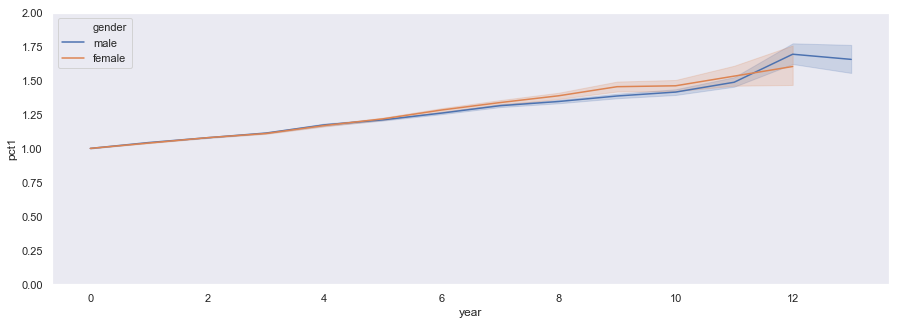

In [73]:
f,ax = plt.subplots(1,1,figsize=(15,5))
# sns.barplot(sample.year,sample.pct1,hue=sample.gender,ax=ax)
sns.lineplot(sample.year,sample.pct1,hue=sample.gender,ax=ax)
ax.set_ylim((0,2))
# ax.set_yscale('log')
ax.grid()

In [72]:
sample.groupby(['year']).gender.value_counts(normalize=True)

year  gender
0     male      0.614065
      female    0.385935
1     male      0.620589
      female    0.379411
2     male      0.634887
      female    0.365113
3     male      0.643732
      female    0.356268
4     male      0.674567
      female    0.325433
5     male      0.704330
      female    0.295670
6     male      0.720949
      female    0.279051
7     male      0.737972
      female    0.262028
8     male      0.757984
      female    0.242016
9     male      0.775843
      female    0.224157
10    male      0.800625
      female    0.199375
11    male      0.852134
      female    0.147866
12    male      0.785425
      female    0.214575
13    male      1.000000
14    male      1.000000
15    male      1.000000
Name: gender, dtype: float64

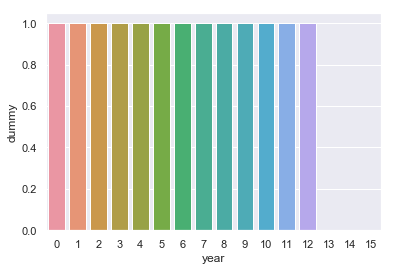

In [71]:
data = sample.groupby(['year']).gender.value_counts(normalize=True).unstack()
data['dummy'] = data.female + data.male
sns.barplot(data.index,data.dummy,)

In [65]:
sample.loc[(sample.year == 0)].pct1.describe()

count    66475.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: pct1, dtype: float64

In [40]:
sample.loc[(sample.year == 1)&(sample.gender == 'male')].pct1.describe()

count    19494.000000
mean         1.043166
std          0.120890
min          0.328620
25%          0.995996
50%          1.028847
75%          1.072370
max          4.039970
Name: pct1, dtype: float64

In [294]:
sample.loc[sample.pct1.isna()]

,Sector,LastName,FirstName,Salary,TaxableBenefits,Employer,JobTitle,CalendarYear,startYear,year,gender,startSalary,raise,pct,ppp,salary_ppp,cpi,salary_cpi,pct1,pct2
id,,,,,,,,,,,,,,,,,,,,
JOHNHAMILTONColleges,Colleges,HAMILTON,JOHN,118978.35,"$5,433.30",Algonquin College,"VP, Finance&Admin.",2000,1999,1,male,NaN,1.044667,NaN,1.227543,96923.977409,0.00954,1.247153e+07,NaN,NaN
FRANKMARSHColleges,Colleges,MARSH,FRANK,160872.71,"$2,751.85",Cambrian College,President,2000,1999,1,male,NaN,1.064721,NaN,1.227543,131052.606711,0.00954,1.686297e+07,NaN,NaN
TIMOTHYMCTIERNANColleges,Colleges,MCTIERNAN,TIMOTHY,124220.40,$204.00,Canadore College,President,2000,1998,2,male,NaN,1.024075,NaN,1.227543,101194.336980,0.00954,1.302101e+07,NaN,NaN
DANIELPATTERSONColleges,Colleges,PATTERSON,DANIEL,156938.31,"$2,909.34",Niagara College,President,2000,1998,2,male,NaN,1.083068,NaN,1.227543,127847.505138,0.00954,1.645056e+07,NaN,NaN
BRIANDESBIENSColleges,Colleges,DESBIENS,BRIAN,155690.02,"$4,251.03",Sir Sandford Fleming College,President,2000,1998,2,male,NaN,1.121531,NaN,1.227543,126830.603897,0.00954,1.631971e+07,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PAULJESSOPUniversities,Universities,JESSOP,PAUL,201208.17,630.16,Wilfrid Laurier University,"Dean, Faculty of Science",2013,1999,14,male,NaN,1.975549,NaN,1.224000,164385.759804,0.01228,1.638503e+07,NaN,NaN
JAMESDARROCHUniversities,Universities,DARROCH,JAMES,343531.68,842.4,York University,Associate Professor,2013,1999,14,male,NaN,3.390029,NaN,1.224000,280663.137255,0.01228,2.797489e+07,NaN,NaN
BENJAMINGEVAUniversities,Universities,GEVA,BENJAMIN,211367.34,319.49,York University,Professor,2013,1998,15,male,NaN,1.994552,NaN,1.224000,172685.735294,0.01228,1.721232e+07,NaN,NaN


In [ ]:
sample.groupby(['gender','year']).pct1.mean().unstack(0)

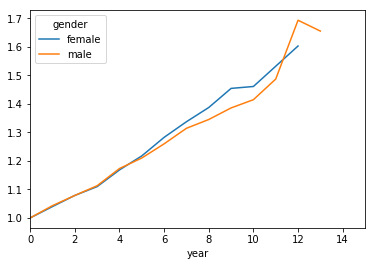

In [273]:
ax = sample.groupby(['gender','year']).pct1.mean().unstack(0).plot()

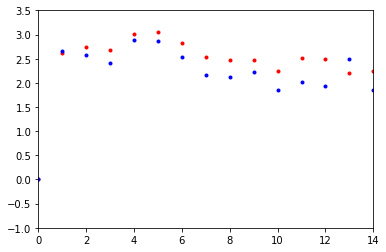

In [137]:
data1 = male[male.CalendarYear != 2014]
data2 = female[female.CalendarYear != 2014]
x = 'duration'
y = 'bump'
gb = data1.groupby(x)
plt.plot(gb[x].mean(), gb[y].median()*100, 'r.')
gb = data2.groupby(x)
plt.plot(gb[x].mean(), gb[y].median()*100, 'b.')
# plt.ylim(-0.03,0.04)
plt.xlim(0,14)
plt.ylim(-1,3.5)
plt.show()


In [133]:
gb.count()

,index,Sector,LastName,FirstName,Salary,TaxableBenefits,Employer,JobTitle,CalendarYear,id,bump,StartYear,gender
duration,,,,,,,,,,,,,
0,48998,48998,48998,48998,48998,48998,48998,48998,48998,48998,48998,48998,48998
1,57127,57127,57127,57127,57127,57127,57127,57127,57127,57127,57127,57127,57127
2,46309,46309,46309,46309,46309,46309,46309,46309,46309,46309,46309,46309,46309
3,32980,32980,32980,32980,32980,32980,32980,32980,32980,32980,32980,32980,32980
4,13157,13157,13157,13157,13157,13157,13157,13157,13157,13157,13157,13157,13157
5,9280,9280,9280,9280,9280,9280,9280,9280,9280,9280,9280,9280,9280
6,6451,6451,6451,6451,6451,6451,6451,6451,6451,6451,6451,6451,6451
7,4512,4512,4512,4512,4512,4512,4512,4512,4512,4512,4512,4512,4512
8,3169,3169,3169,3169,3169,3169,3169,3169,3169,3169,3169,3169,3169


# All names in lowercase

(array([6.3353e+04, 1.3939e+04, 4.1840e+03, 1.0720e+03, 8.6400e+02,
        2.6000e+02, 1.2700e+02, 7.3000e+01, 5.0000e+01, 2.3000e+01,
        1.4000e+01, 6.0000e+00, 6.0000e+00, 5.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 100000.02  ,  142235.9848,  184471.9496,  226707.9144,
         268943.8792,  311179.844 ,  353415.8088,  395651.7736,
         437887.7384,  480123.7032,  522359.668 ,  564595.6328,
         606831.5976,  649067.5624,  691303.5272,  733539.492 ,
         775775.4568,  818011.4216,  860247.3864,  902483.3512,
         944719.316 ,  986955.2808, 1029191.2456, 1071427.2104,
        1113663.1752, 1155899.14  ]),
 <a list of 25 Patch objects>)

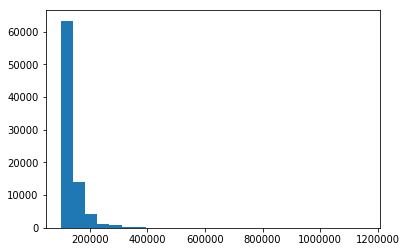

In [72]:
plt.hist(dup[dup.CalendarYear == 2016].Salary,bins=25)

In [145]:
df.loc[df.Salary > 1e7]

,Sector,LastName,FirstName,Salary,TaxableBenefits,Employer,JobTitle,CalendarYear,id
146904,Municipalities and Services,HARRIS,STEPHEN,12805985.0,"$11,587.55",City of Toronto - Toronto Police Service,Staff Inspector,2006,STEPHENHARRISMunicipalities and Services
162732,Hospitals and Boards of Public Health,YELLE-WEATHERALL,JOANNE,12745500.0,$483.52,SCO Health Service,"Director Operations, Elisabeth-Bruyère Researc...",2006,JOANNEYELLE-WEATHERALLHospitals and Boards of ...
